# ORgenes

In [1]:
if (!require("gridExtra", quietly = TRUE)) {
  install.packages("gridExtra")
}

if (!require("data.table", quietly = TRUE)) {
  install.packages("data.table")
}

if (!require("ggplot2", quietly = TRUE)) {
  install.packages("ggplot2")
}


In [2]:
library(ggplot2)
library(data.table)
library(gridExtra)

In [3]:
or_genes <- read.csv("data/ORgenes.csv")
or_genes[
  which(or_genes$Species == "Loxodonta Africana"),
  "Species"
] <- "Loxodonta africana"


In [4]:
write.table(
  or_genes$Species,
  "data/species.txt",
  row.names = FALSE,
  col.names = FALSE,
  quote = FALSE
)


## Five summary statistics
Determine the 5 summary statistics for Functional and non-functional OR gene numbers.

In [5]:
func_summary <- summary(or_genes$Functional)
func_summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  139.0   703.0   821.5   757.8   917.8  1765.0 

In [6]:
non_func_summary <- summary(or_genes$NonFuctional)
non_func_summary


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  193.0   521.5   826.0   900.1  1199.2  2646.0 

In [7]:
func_summary <- as.data.frame(as.matrix(func_summary))
colnames(func_summary) <- "Functional"
non_func_summary <- as.data.frame(as.matrix(non_func_summary))
colnames(non_func_summary) <- "NonFunctional"

five_stat_summary <- merge(func_summary, non_func_summary, by = 0)
rownames(five_stat_summary) <- five_stat_summary[, "Row.names"]
five_stat_summary$Row.names <- NULL

write.csv(
  five_stat_summary,
  "data/five_stat_summary.csv"
)


In [8]:
or_genes_long <- melt(
  setDT(or_genes),
  measure.vars = c("Functional", "NonFuctional")
)

head(or_genes_long)

Species,Activity.Pattern,variable,value
<chr>,<chr>,<fct>,<int>
Bison bison,CATHEMERAL,Functional,836
Bubalus bubalis,CATHEMERAL,Functional,751
Cricetulus griseus,CATHEMERAL,Functional,851
Equus caballus,CATHEMERAL,Functional,931
Equus przewalskii,CATHEMERAL,Functional,761
Loxodonta africana,CATHEMERAL,Functional,1765


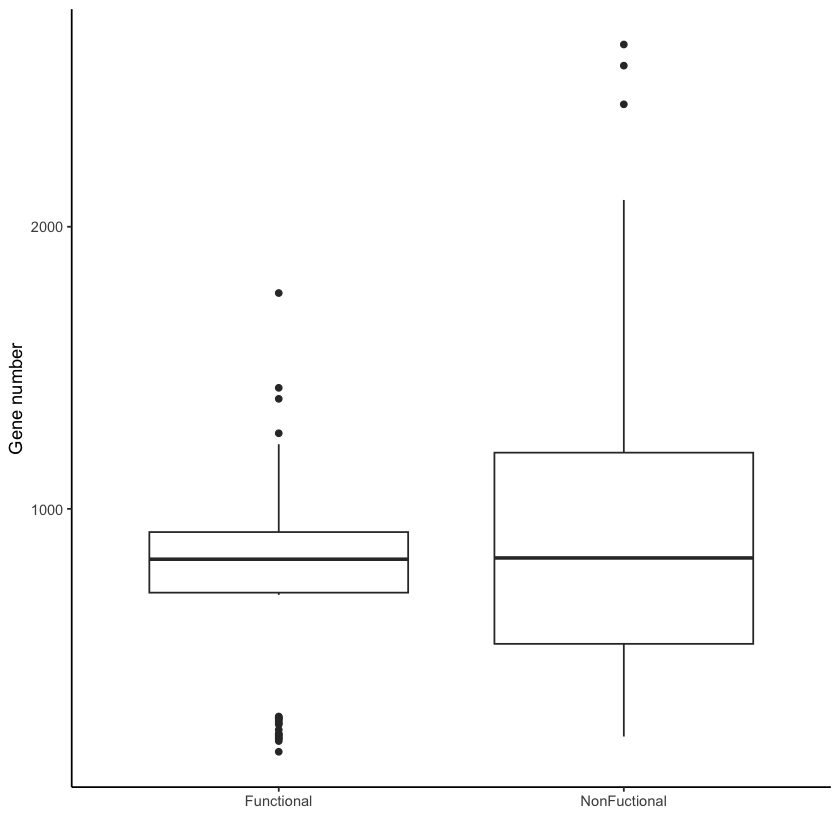

In [9]:
p <- ggplot(or_genes_long, aes(variable, value)) +
  geom_boxplot() +
  xlab("") +
  ylab("Gene number") +
  theme_classic()

p
ggsave("plots/boxplot.png", width = 3, height = 3)

## Normality test
Run a test for normality to see if functional and on-functional OR numbers are normally distributed.

In [10]:
shapiro.test(or_genes$Functional)


	Shapiro-Wilk normality test

data:  or_genes$Functional
W = 0.89311, p-value = 2.523e-06


In [11]:
shapiro.test(or_genes$NonFuctional)


	Shapiro-Wilk normality test

data:  or_genes$NonFuctional
W = 0.90202, p-value = 6.178e-06


Both have p-value less than 0.05, so they are not normally distributed.

In [12]:
func_gene_hist <- ggplot(or_genes, aes(Functional, fill = Activity.Pattern)) +
  geom_histogram(position = "stack") +
  theme_classic() +
  theme(plot.title = element_text(hjust = 0.5)) +
  ggtitle("Functional gene number histogram") +
  xlab("Shapiro-Wilk test p value 2.523e-06")


In [13]:
non_func_gene_hist <- ggplot(
  or_genes,
  aes(NonFuctional, fill = Activity.Pattern)
) +
  geom_histogram(position = "stack") +
  theme_classic() +
  theme(plot.title = element_text(hjust = 0.5)) +
  ggtitle("Non-functional gene number histogram") +
  xlab("Shapiro-Wilk test p value 6.178e-06")


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Saving 7 x 7 in image


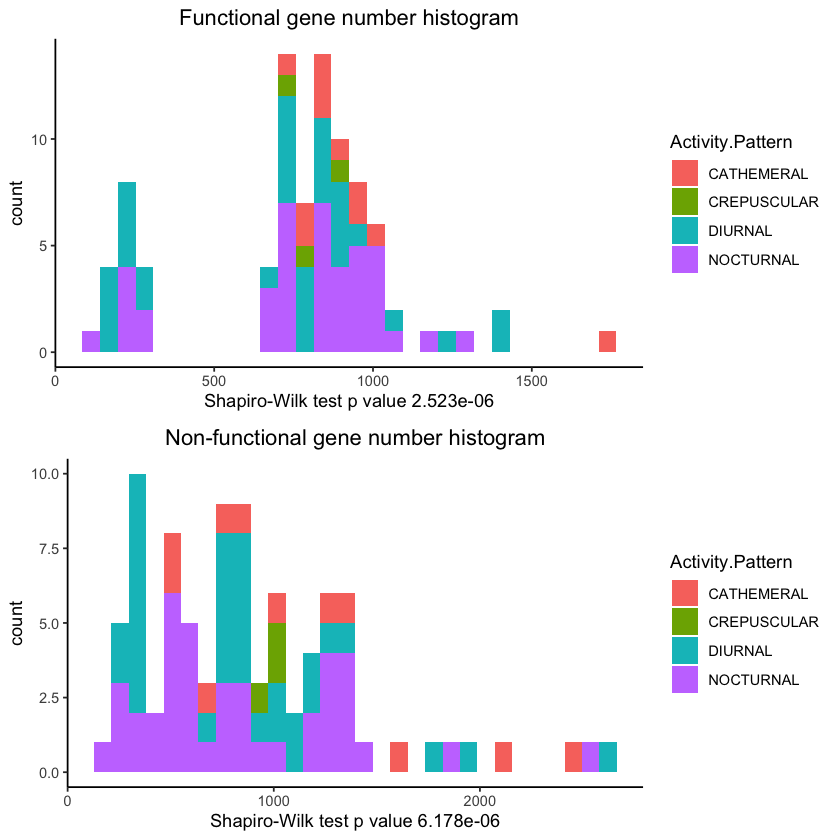

In [14]:
g <- arrangeGrob(func_gene_hist, non_func_gene_hist)
grid.arrange(g)

ggsave("plots/gene_hist.png", g)

## Clustering analysis
Cluster your data for functional and non-functional OR numbers independently to see if there is a clear clustering pattern based on your activity pattern. Clustering can be k-means or PCA.

In [15]:
set.seed(12345)

run_kmeans <- function(or_genes, n_cluster, gene_type) {
  cluster_res <- kmeans(or_genes[, gene_type], n_cluster)
  res <- cbind(
    or_genes,
    paste0("cluster_", as.character(cluster_res$cluster))
  )
  colnames(res) <- c(colnames(or_genes), "Cluster")
  return(res)
}

plot_kmeans_result <- function(clustered_or_genes) {
  df <- table(clustered_or_genes[, c("Activity.Pattern", "Cluster")])
  df <- as.data.frame(df)
  heatmap_plot <- ggplot(df, aes(
    Cluster,
    Activity.Pattern,
    fill = Freq
  )) +
    geom_tile() +
    geom_text(aes(label = Freq)) +
    scale_fill_gradient(low = "white", high = "red")
  bar_plot <- ggplot(df, aes(Activity.Pattern, Freq, fill = Cluster)) +
    geom_bar(stat = "identity") +
    theme_classic() +
    theme(plot.title = element_text(hjust = 0.5))
  p <- bar_plot
  return(p)
}


In [16]:
or_genes <- as.data.frame(or_genes)

functional_genes <- run_kmeans(or_genes, 3, "Functional")
func_gene_kmeans <- plot_kmeans_result(functional_genes) +
  ggtitle("Functional gene number kmeans clustering")


In [17]:
non_functional_genes <- run_kmeans(or_genes, 3, "NonFuctional")
non_func_gene_kmeans <- plot_kmeans_result(non_functional_genes) +
  theme(plot.title = element_text(hjust = 0.5)) +
  ggtitle("Non-functional gene number kmeans clustering")


Saving 7 x 7 in image


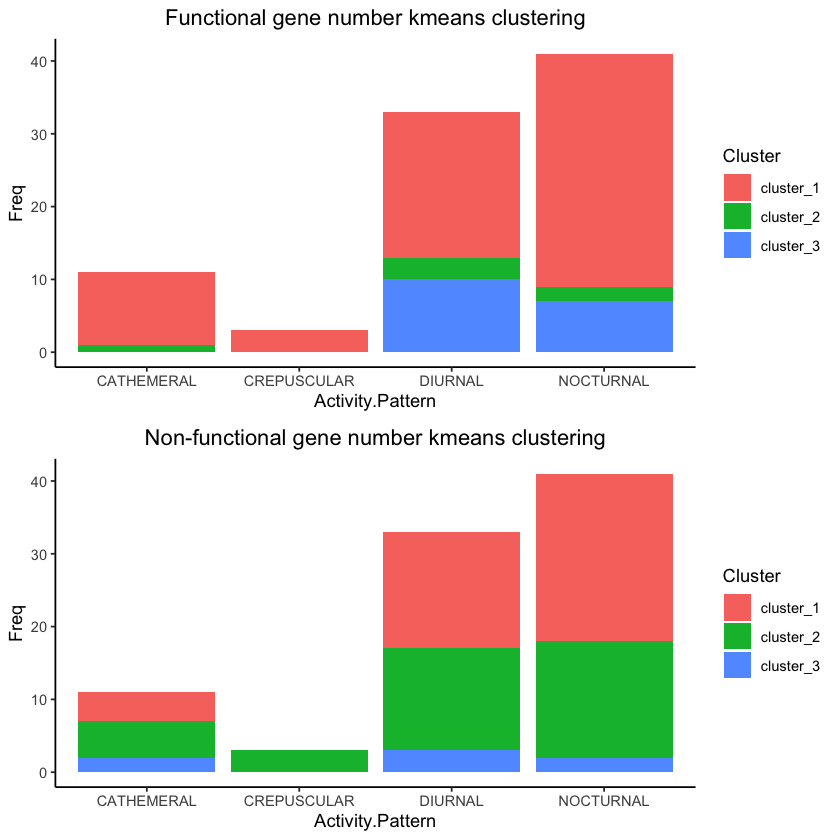

In [18]:
g <- arrangeGrob(func_gene_kmeans, non_func_gene_kmeans)
grid.arrange(g)

ggsave("plots/gene_kmeans.png", g)


## Correlation test
Determine if a correlation exists between both functional and non-functional OR gene numbers, based on whether your data is normal or not.

In [19]:
cor.test(
  or_genes$Functional,
  or_genes$NonFuctional,
  method = "spearman",
  exact = FALSE
)


	Spearman's rank correlation rho

data:  or_genes$Functional and or_genes$NonFuctional
S = 35298, p-value = 1.143e-13
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.6891765 


The p-value is $1.143 * 10^{-13}$ which is less than 0.05, so there might be a correlation between functional gene and non-functional gene number

## Statistical hypothesis test
Use an appropriate hypothesis test to determine if a significant difference exists between activity patterns with respect to functional OR gene numbers.

In [20]:
normality_test <- function(or_genes, gene_type) {
  values <- or_genes[c("Activity.Pattern", gene_type)]
  values <- split(values, values$Activity.Pattern)
  res <- lapply(values, function(i) {
    shapiro.test(i[, gene_type])
  })
  return(res)
}


In [21]:
normality_test_res <- normality_test(or_genes, "Functional")
for (pat in names(normality_test_res)) {
  cat(pat, "\n")
  print(normality_test_res[[pat]])
}


CATHEMERAL 

	Shapiro-Wilk normality test

data:  i[, gene_type]
W = 0.63574, p-value = 7.12e-05

CREPUSCULAR 

	Shapiro-Wilk normality test

data:  i[, gene_type]
W = 0.82775, p-value = 0.1826

DIURNAL 

	Shapiro-Wilk normality test

data:  i[, gene_type]
W = 0.88435, p-value = 0.002143

NOCTURNAL 

	Shapiro-Wilk normality test

data:  i[, gene_type]
W = 0.87755, p-value = 0.0003847



In [22]:
kruskal.test(Activity.Pattern ~ Functional, data = or_genes)


	Kruskal-Wallis rank sum test

data:  Activity.Pattern by Functional
Kruskal-Wallis chi-squared = 82.859, df = 80, p-value = 0.3913


The p-value is 0.3913 which is greater than 0.05, so there might be no significnat difference between activity patterns with respect to functional OR gene numbers.

In [23]:
contingency_table <- table(functional_genes[c("Activity.Pattern", "Cluster")])
contingency_table
fisher.test(contingency_table)


                Cluster
Activity.Pattern cluster_1 cluster_2 cluster_3
     CATHEMERAL         10         1         0
     CREPUSCULAR         3         0         0
     DIURNAL            20         3        10
     NOCTURNAL          32         2         7


	Fisher's Exact Test for Count Data

data:  contingency_table
p-value = 0.2659
alternative hypothesis: two.sided


In [24]:
write.csv(
  contingency_table,
  "data/cluster_contingency.csv",
  quote = FALSE
)